# Advanced Signal Processing


In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Optional
from matplotlib import rcParams

rcParams['savefig.dpi'] = 600

In [18]:
def norm(x):
    return np.sqrt(sum(x**2))


def projection(y, x, epsilon, hk):
    v = x @ hk - y
    if v + epsilon < 0:
        beta = (-v - epsilon) / norm(x)**2
    elif v - epsilon > 0:
        beta = (-v + epsilon) / norm(x)**2
    else:
        beta = 0
    return hk + beta * x


def APSM(
    y,
    X,
    epsilon: float,
    factor: float,
    q: int,
    ) -> List[float]:
    N, l = X.shape
    assert N == y.shape[0]
    hk_1 = np.random.normal(loc=0, scale=1, size=l)
    hk_iter = [hk_1]
    for n in range(1, N):
        # updating the parameter
        idx = [i for i in range(max(0, n - q), n)]
        w = np.ones(min(n, q))
        w /= sum(w)  # Weights are normalized

        X_active = X[idx, :]
        y_active = y[idx]

        Ps = [
            projection(yy, xx, epsilon, hk_1)
            for yy, xx in zip(y_active, X_active)
            ]
        const = norm(hk_1 - sum(w[:, np.newaxis] * Ps))**2
        M = w @ np.array([norm(p - hk_1)**2 for p in Ps]) / const
        mu = factor * M
        hk = hk_1 + mu * (sum(w[:, np.newaxis] * Ps) - hk_1)
        hk_iter.append(hk)
        hk_1 = hk
    return hk_iter

In [28]:
# Generate data
np.random.seed(0)
X = np.random.normal(loc=0, scale=1, size=(3500, 100))  # Observations
N, l = X.shape
reference = np.random.normal(loc=0, scale=1, size=l)  #
eta = np.random.normal(loc=0, scale=0.1, size=N)  # Noise
y = X @ reference + eta

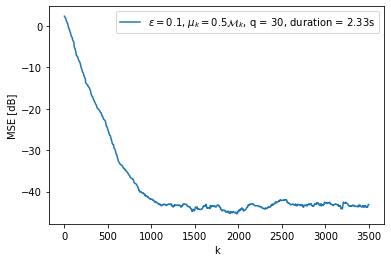

In [29]:
def plot_APSM(
    y,
    X,
    reference,
    epsilon: float = 0.1,
    factor: float = 0.5,
    q: int = 30,
    ax: Optional[plt.Axes] = None,
    ) -> None:
    if ax is None:
        _, ax = plt.subplots(1)
    start = time.time()
    hk_iter = APSM(y, X, epsilon=epsilon, factor=factor, q=q)
    mse = [10 * np.log10(np.mean((reference - hk)**2)) for hk in hk_iter]
    duration = time.time() - start
    ax.plot(
        mse,
        label=(
            f"$\epsilon = {epsilon}$, "
            f"$\mu_k = {factor} \mathcal{{M}}_k$, "
            f"q = {q}, "
            f"duration = {duration:.2f}s"
            )
        )
    ax.set_ylabel('MSE [dB]')
    ax.set_xlabel('k')
    plt.legend(loc='upper right')


plot_APSM(y, X, reference, epsilon=0.1, factor=0.5, q=30)

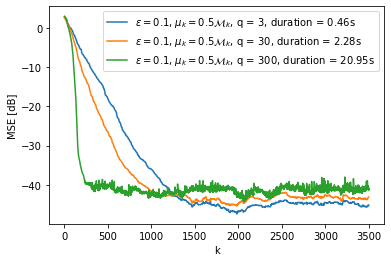

In [30]:
fig, ax = plt.subplots(1)
for q in [3, 30, 300]:
    plot_APSM(y, X, reference, q=q, ax=ax)
fig.savefig('simulation-random-q.png')

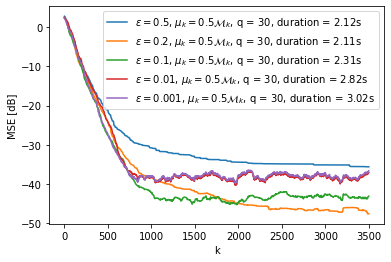

In [32]:
fig, ax = plt.subplots(1)
for epsilon in [0.5, 0.2, 0.1, 0.01, 0.001]:
    plot_APSM(y, X, reference, epsilon=epsilon, ax=ax)
fig.savefig('simulation-random-epsilon.png')

C:\Users\esdan\AppData\Local\Temp\ipykernel_22432\777967725.py:41: RuntimeWarning: invalid value encountered in double_scalars
  M = w @ np.array([norm(p - hk_1)**2 for p in Ps]) / const


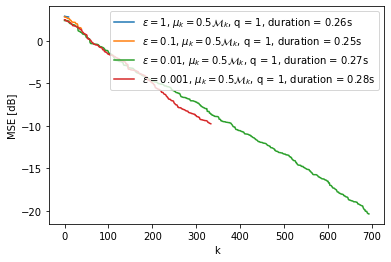

In [23]:
fig, ax = plt.subplots(1)
for epsilon in [1, 0.1, 0.01, 0.001]:
    plot_APSM(y, X, reference, q=1, epsilon=epsilon, ax=ax)

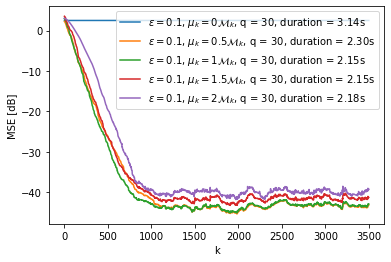

In [24]:
fig, ax = plt.subplots(1)
for factor in [0, 0.5, 1, 1.5, 2]:
    plot_APSM(y, X, reference, factor=factor, ax=ax)

In [25]:
import pandas as pd

data = pd.read_csv('train.csv')
data.head()

X_columns = ['GrLivArea', 'OverallQual', 'GarageCars', 'GarageArea']
y_column = 'SalePrice'
_data = data[X_columns + [y_column]]
norm_data = (_data - _data.mean()) / _data.std()
X = norm_data.loc[:, X_columns].dropna()
X_train = X.sample(frac=0.8, random_state=0)
X_test = X.drop(X_train.index)
y_train = norm_data[y_column].iloc[X_train.index].to_numpy()
y_test = norm_data[y_column].iloc[X_test.index].to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (1168, 4)
y_train.shape = (1168,)
X_test.shape = (292, 4)
y_test.shape = (292,)


C:\Users\esdan\AppData\Local\Temp\ipykernel_22432\777967725.py:41: RuntimeWarning: invalid value encountered in double_scalars
  M = w @ np.array([norm(p - hk_1)**2 for p in Ps]) / const


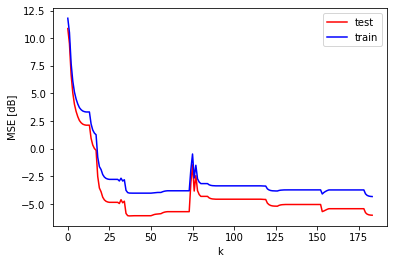

In [26]:
np.random.seed(0)
hk_iter = APSM(y_train, X_train, epsilon=1, factor=0.5, q=5)

mse_train = [
    10 * np.log10(np.mean((X_train @ hk - y_train)**2)) for hk in hk_iter
    ]
mse_test = [10* np.log10(np.mean((X_test @ hk - y_test)**2)) for hk in hk_iter]

fig, ax = plt.subplots(1)
ax.plot(mse_test, color='r', label='test')
ax.plot(mse_train, color='b', label='train')
ax.set_ylabel('MSE [dB]')
ax.set_xlabel('k')
ax.legend(loc='upper right')
fig.savefig('simulation-kaggle.png')